In [1]:
import os

import pymc as pm
import pandas as pd
import numpy as np
import pickle
import cloudpickle
import gzip
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import cobra
sns.set(context="talk", style="ticks", color_codes=True, rc={"legend.frameon": False})

%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.getcwd()

'/Users/mcna892/Library/CloudStorage/OneDrive-PNNL/Desktop/Projects/Bayesian/syn_bmca/src'

In [12]:
syn_model_fname = "../models/syn_elong_flipped_no_zero_nocofactors.json"
syn_model = cobra.io.load_json_model(syn_model_fname)
#syn_model =cobra.io.read_sbml_model(syn_model_fname)


Set parameter TokenServer to value "leghorn.emsl.pnl.gov"


In [136]:
with gzip.open("/Users/mcna892/Downloads/ADVI_40k_vnss.pgz", "rb") as f:
    advi_results = cloudpickle.load(f)

In [137]:
with gzip.open("/Users/mcna892/Downloads/ModelData_40_vnss.pgz", "rb") as f:
    pymc_data = cloudpickle.load(f)

In [138]:
pymc_data.keys()

dict_keys(['model', 'vn', 'en', 'xn', 'x_inds', 'e_inds', 'v_inds', 'll', 'v_star'])

In [139]:
dir(advi_results['model'])

['Ex',
 'RV_dims',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_config_context',
 '_context_class',
 '_coords',
 '_dim_lengths',
 '_parent',
 '_pytensor_config',
 '_repr_latex_',
 '_validate_name',
 'add_coord',
 'add_coords',
 'add_named_variable',
 'basic_RVs',
 'check_bounds',
 'check_start_vals',
 'chi_obs',
 'compile_d2logp',
 'compile_dlogp',
 'compile_fn',
 'compile_logp',
 'cont_vars',
 'contexts',
 'continuous_value_vars',
 'coords',
 'create_value_var',
 'd2logp',
 'datalogp',
 'debug',
 'deterministics',
 'dim_lengths',
 'disc_vars',
 'discrete_value_vars',
 'd

In [140]:
advi_results['model'].model

 ex_kinetic_entries ~ HalfNormal(0, 1)
ex_capacity_entries ~ Laplace(0, 0.01)
     log_e_measured ~ Normal(<constant>, 0.2)
   log_e_unmeasured ~ Laplace(0, 0.1)
               yn_t ~ Normal(0, 10)
                 Ex ~ Deterministic(f(ex_capacity_entries, ex_kinetic_entries))
           log_en_t ~ Deterministic(f(log_e_unmeasured, log_e_measured))
              vn_ss ~ Deterministic(f(log_e_unmeasured, log_e_measured, yn_t, ex_capacity_entries, ex_kinetic_entries))
            chi_obs ~ Normal(0, 0.2)
             vn_obs ~ Normal(f(log_e_unmeasured, log_e_measured, yn_t, ex_capacity_entries, ex_kinetic_entries), 0.1)

In [141]:
trace = advi_results['hist'].sample(500)

In [142]:
trace

Inference data with groups:
	> posterior
	> observed_data

In [143]:
trace_post_Ex = trace.posterior['Ex'][0].to_numpy()
trace_post_Ex.shape

(500, 396, 927)

## Make FCC box plots

In [144]:
ll = pymc_data['ll']
ll

In [145]:
r_labels = [r.id for r in syn_model.reactions]
target_rxn = 'SUCRt2'

In [146]:


fcc = pd.DataFrame(
    np.array(
        [
            ll.flux_control_coefficient(Ex=ex)[r_labels.index(target_rxn)]
            for ex in tqdm(trace.posterior['Ex'][0].to_numpy())
        ]
    ),
    columns=r_labels,
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [16:31<00:00,  1.98s/it]


In [147]:
fcc

,O2tcx,DTMPK,BIOMASS__1,3HAD160,RNDR3,Htex,G5SD,HISTDa,TRPS3,U23GAAT2,...,EX_photon650_e,EX_photon690_e,GHMT2r,EX_pi_e,ILETA,VALTA,TYRTA,SUCRt2,3OAR40_1,AOOA
0,0.000034,0.001150,0.000399,-0.000421,-0.000814,0.000830,-0.000935,-0.000637,0.003118,0.000027,...,0.0,0.000126,-0.000557,-0.000930,0.000608,0.000397,-0.001082,0.225102,0.001502,0.000083
1,0.000023,-0.000006,0.000251,-0.000945,-0.001317,0.003564,-0.000831,-0.000124,0.001274,0.001005,...,0.0,0.000199,0.000273,-0.002873,0.000348,0.000416,-0.001108,0.202735,-0.000591,0.001436
2,-0.000016,0.001245,-0.000437,-0.001364,-0.000947,0.000993,-0.001850,0.000224,0.001842,0.000328,...,0.0,0.000355,0.000272,-0.000495,-0.000309,0.000102,0.000213,0.229363,-0.000618,0.001557
3,0.000004,0.000355,0.000077,-0.000767,-0.000689,0.000429,-0.001792,0.001260,0.002106,-0.000212,...,0.0,0.000646,-0.000543,-0.003395,0.000765,0.000511,-0.000408,0.212039,0.000649,0.001064
4,-0.000010,0.000030,-0.000002,-0.001258,-0.001000,0.001690,-0.001538,0.000105,0.001660,0.000187,...,0.0,0.000317,-0.000324,0.000040,0.000199,-0.000359,0.001079,0.205885,-0.000137,0.001439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000030,0.000676,-0.000533,-0.000607,-0.000406,0.000489,-0.001160,-0.000843,0.002147,0.000661,...,0.0,0.000535,0.001121,0.001859,0.000304,0.000028,0.000097,0.232371,0.001506,0.000808
496,0.000017,-0.000578,0.000113,-0.000373,-0.000737,0.000527,0.000045,0.000256,0.002260,0.000837,...,0.0,0.000155,-0.000570,-0.002882,-0.000113,0.000213,0.000874,0.205023,0.001382,0.001620
497,0.000045,0.000378,-0.000647,-0.000016,-0.001134,0.002129,-0.002025,-0.000011,0.003171,-0.000002,...,0.0,0.000511,0.001136,-0.001150,0.000703,0.001334,-0.000503,0.187613,0.000768,0.001191
498,0.000002,0.000639,0.000404,-0.000148,-0.001074,-0.000195,-0.000908,-0.000024,0.002011,0.000297,...,0.0,0.000069,-0.000199,-0.001206,-0.000472,-0.000258,-0.001070,0.218692,-0.000097,0.001045


In [148]:
fcc = fcc.drop([col for col in fcc if col.startswith('EX_')], axis=1)


In [149]:
fcc_sort = fcc.reindex(columns=fcc.median().sort_values().index)
# fcc_prior_sort = fcc_prior.reindex(columns=fcc.median().sort_values().index)

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hdi = pm.hdi(fcc_sort.values)
# hpd_prior = pm.hpd(fcc_prior_sort.values)

fcc_consistent = np.sign(hdi[:, 0]) == np.sign(hdi[:, 1])


/var/folders/1f/ksln774x1hd1pzfgsjgpxt7r0000gn/T/ipykernel_55561/2829467274.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pm.hdi(fcc_sort.values)


In [150]:
sum(fcc_consistent)

44

In [111]:
y_max = 0.2

Text(-0.7916666666666696, 0.5, 'FCC (Sucrose)')

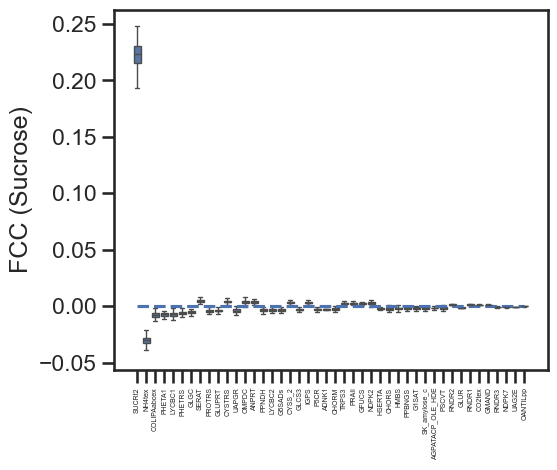

In [156]:
sns.boxplot(
    x="variable",
    y="value",
    data=fcc_sort.loc[:, fcc_consistent].melt(),
    order=fcc_sort.loc[:, fcc_consistent]
    .median()
    .abs()
    .sort_values(ascending=False)
    .index[:sum(fcc_consistent)],
    fliersize=0,
)
#y_min = -0.01#fcc_sort.loc[:, fcc_consistent].melt()['value'].min()  # Calculate min
#y_max = 0.2#fcc_sort.loc[:, fcc_consistent].melt()['value'].max()  # Calculate max

#plt.ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))  # Add a bit of padding
plt.tight_layout()
plt.hlines([0], 0, (sum(fcc_consistent)-1), linestyles="dashed")
plt.xticks(rotation=90, fontsize=5)
plt.xlabel(None)
plt.ylabel("FCC (Sucrose)")
#plt.savefig("Syn_FCC_ADVI_40k_vnss.png", dpi=300, bbox_inches="tight")

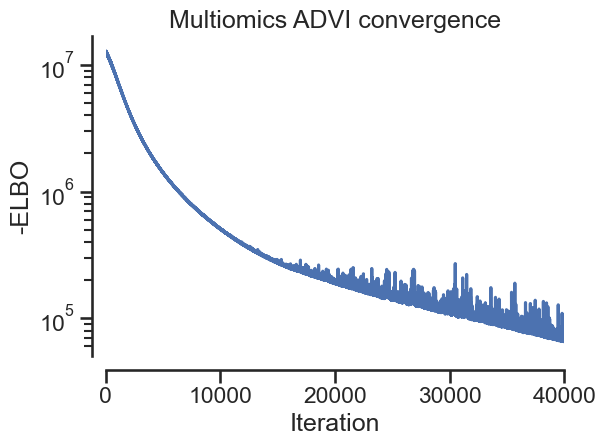

In [153]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.semilogy(advi_results['hist'].hist, '-', ms=1, rasterized=True)
ax.set_xlim([0, 40000])

sns.despine(offset=10)
ax.set_xlabel('Iteration')
ax.set_ylabel('-ELBO')
ax.set_title('Multiomics ADVI convergence')

plt.tight_layout()
#plt.savefig("Syn_ELBO_ADVI_40k_vnss.png", dpi=300, bbox_inches="tight")

In [83]:
fccs = fcc.to_numpy(dtype="float")
fccs

array([[ 1.76844652e-03, -5.35267603e-04, -4.42832939e-04, ...,
        -3.78278225e-02, -2.16995593e-04,  3.30499165e-04],
       [ 2.14337961e-03,  5.61766466e-04, -8.90979086e-05, ...,
        -3.87029048e-02, -1.35713416e-03,  8.20456049e-04],
       [ 1.78407840e-03,  1.17997629e-04, -5.25786855e-04, ...,
        -3.63276269e-02, -1.18145715e-03, -2.54383587e-04],
       ...,
       [ 1.27516252e-03, -2.46603676e-05,  7.43333864e-05, ...,
        -4.07671273e-02, -3.68579931e-04, -4.83901675e-04],
       [ 1.47491892e-03, -8.92830849e-05, -4.10055280e-04, ...,
        -3.75158946e-02, -5.33876503e-04,  4.96874315e-04],
       [ 2.04634563e-03,  6.73503041e-04, -2.15207361e-04, ...,
        -3.97557727e-02, -3.72436340e-04, -1.40324367e-03]])

In [84]:
def plot_hpd(ax, real, ppc, error=True, ms=3, alpha=0.5, color='b'):
    if error:
        ax.plot(np.vstack([real.values.flatten(), real.values.flatten()]),
                pm.hdi(ppc).to_array().to_numpy().reshape(-1, 2).T, color=color, lw=1, alpha=0.05, zorder=0)
    ax.plot(real, ppc.median(dim=['chain','draw']), '.', ms=ms, color=color, alpha=alpha, zorder=0)

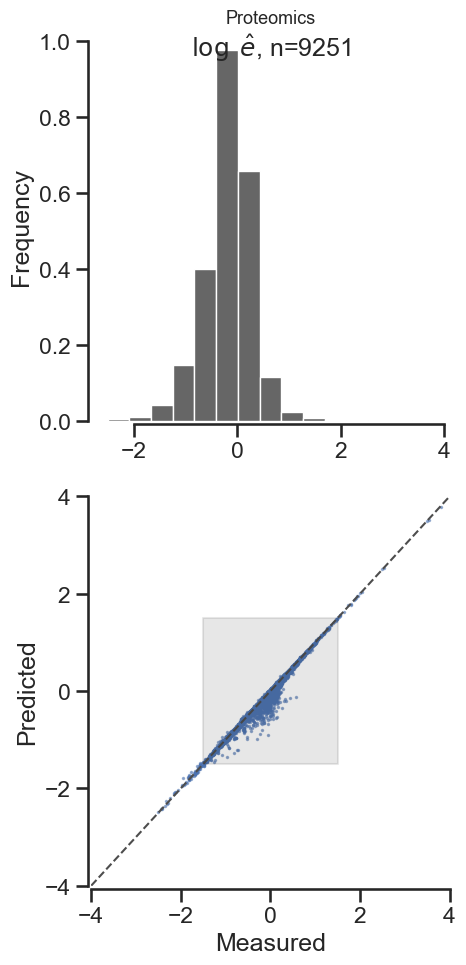

In [154]:
en = pymc_data['en']
e_inds = pymc_data['e_inds']

plt.rcParams["axes.axisbelow"] = False

fig, ax_matrix = plt.subplots(ncols=1, nrows=2, figsize=(5, 10), sharex='row')  # 2 rows for subplots

# Histogram subplot (ax_matrix[0])
ax_matrix[0].hist(np.log(en.values.flatten()), bins=15, lw=1, edgecolor='w',
                  density=True, facecolor='.4')
ax_matrix[0].set_title('Proteomics', fontsize=13)
ax_matrix[0].text(0.5, 1., '$\log\; \hat{e}$, n=' + str(en.shape[0] * en.shape[1]),
               ha='center', va='top', transform=ax_matrix[0].transAxes)
ax_matrix[0].set_ylabel('Frequency')

# Scatter plot subplot (ax_matrix[1])
plot_hpd(ax_matrix[1], np.log(en),
         trace.posterior['log_en_t'][:, :, :, e_inds], error=False)
ax_matrix[1].set_rasterization_zorder(1)
ax_matrix[1].set_xlim([-4, 4])
ax_matrix[1].set_ylim([-4, 4])
ax_matrix[1].set_xticks([-4, -2, 0, 2, 4])
ax_matrix[1].plot([-4, 4], [-4, 4], '--', color='.3', zorder=4, lw=1.5)
ax_matrix[1].set_yticks([-4, -2, 0, 2, 4])
ax_matrix[1].fill_between([-1.5, 1.5], [1.5, 1.5], [-1.5, -1.5],
                       zorder=4, color='k', alpha=.1)
ax_matrix[1].set_xlabel('Measured')
ax_matrix[1].set_ylabel('Predicted')


sns.despine(offset=2.5, trim=True)
plt.tight_layout()
#plt.savefig('Syn_Parity_ADVI_40k_vnss.png', dpi=300)



In [87]:
vn = pymc_data['vn']

In [88]:
def corrwith(left, right, df=True):
    # demeaned data
    left_tiled = np.repeat(left.values[:, np.newaxis, :], right.shape[0], 1)
    right_tiled = np.repeat(right.values[np.newaxis, :, :], left.shape[0], 0)

    ldem = left_tiled - left_tiled.mean(-1)[:, :, np.newaxis]
    rdem = right_tiled - right_tiled.mean(-1)[:, :, np.newaxis]

    num = (ldem * rdem).sum(-1)

    dom = (left.shape[1] - 1) * left_tiled.std(-1) * right_tiled.std(-1)
    correl = num / dom
    
    if not df:
        return correl
    else: 
        return pd.DataFrame(correl, index=left.index, columns=right.index)

corr_df = corrwith(en, vn).T

ValueError: operands could not be broadcast together with shapes (29,29,319) (29,29,396) 

In [62]:
def random_corr_iterator():
    return corrwith(e.loc[:, np.random.permutation(e.columns)],
                    v.loc[:, np.random.permutation(e.columns)], df=False)

In [63]:
permuted_corr_mat = np.array([random_corr_iterator() for _ in tqdm(range(2000))])

  0%|                                                                                                      | 0/2000 [00:00<?, ?it/s]

NameError: name 'e' is not defined

In [ ]:
import scipy
from scipy import cluster

z_scores = (corr_df - permuted_corr_mat.mean(0).T) / permuted_corr_mat.std(0).T
p_vals = 2 * z_scores.abs().apply(scipy.stats.norm.sf)

def sort_df(df):
    sort_x = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df, "complete"))
    sort_y = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df.T, "complete"))
    
    return df.iloc[sort_x, sort_y]

In [ ]:
# Initialize an empty array to store HDI results
fccs_hdi = np.zeros((240, 240, 2))

# Calculate HDI for each slice along the first dimension
for i in range(fccs.shape[1]):
    for j in range(fccs.shape[2]):
        hdi = pm.hdi(fccs[:, i, j])  # Compute HDI for each element (across the 500 dimension)
        fccs_hdi[i, j] = hdi  # Store HDI results

In [ ]:
fcc_consistent = np.sign(fccs_hdi[:, :, 0]) == np.sign(fccs_hdi[:, :, 1])
fcc_consistent_df = pd.DataFrame(fcc_consistent, columns=r_labels, index=r_labels)

In [56]:
sorted_corr_df = sort_df(corr_df)

fcc_med_measured = fcc_med.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)
fcc_consistent_measured = fcc_consistent_df.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)

NameError: name 'sort_df' is not defined

In [54]:
fccs_hpd = pm.hdi(fcc)
fcc_consistent = np.sign(fccs_hpd[:, :, 0]) == np.sign(fccs_hpd[:, :, 1])
fcc_consistent_df = pd.DataFrame(fcc_consistent, columns=r_labels, index=r_labels)

sorted_corr_df = sort_df(corr_df)

fcc_med_measured = fcc_med.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)
fcc_consistent_measured = fcc_consistent_df.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)

ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not DataFrame

NameError: name 'sorted_corr_df' is not defined

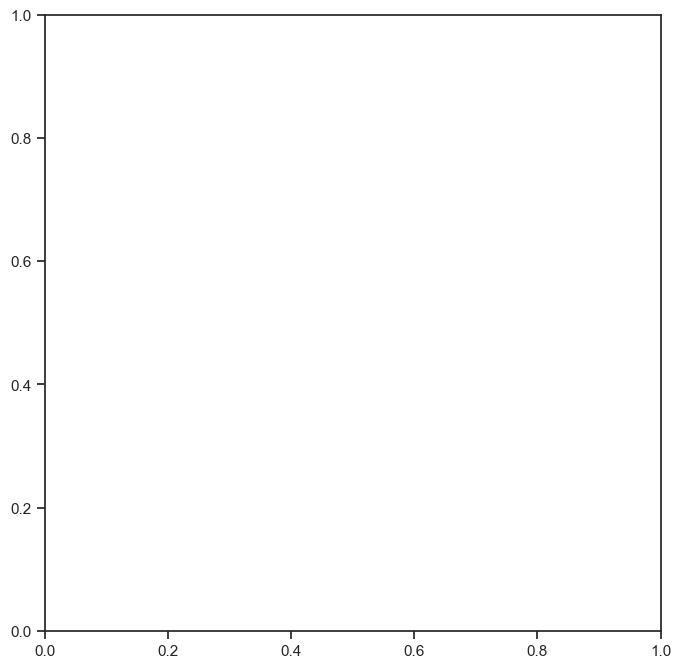

In [52]:
with sns.plotting_context('notebook'):
    fig = plt.figure(figsize=(40,8))
    ax = fig.add_subplot(111, aspect='equal', adjustable='box')

sns.heatmap(sorted_corr_df[p_vals < 0.05].values, vmin=-1, vmax=1,
            cmap='RdBu', cbar=True, rasterized=True, lw=1)

_= ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_= ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_ = ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_ = ax.set_xticklabels(sorted_corr_df.columns)

ax.set_xlabel('Enzyme')
ax.set_ylabel('Boundary Flux')

plt.tight_layout()
# plt.savefig('corr_heatmap_large_confident.svg', dpi=75)

NameError: name 'fcc_med_measured' is not defined

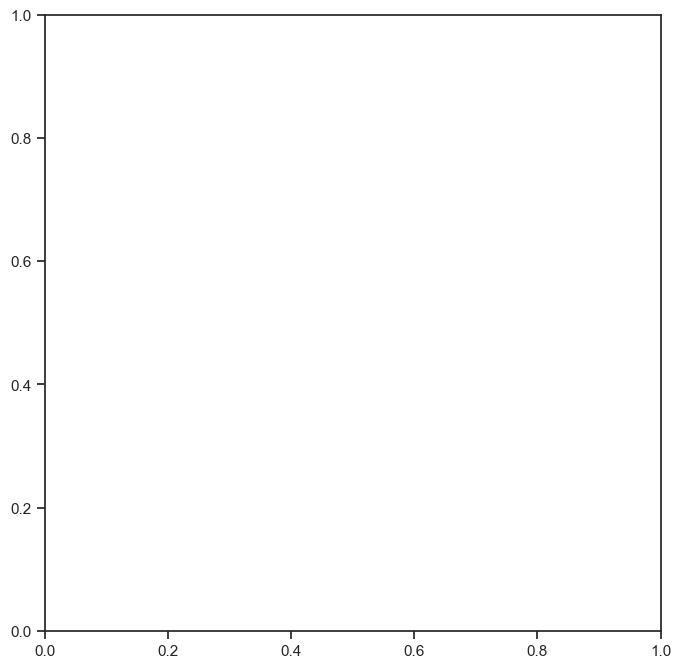

In [55]:
with sns.plotting_context('notebook'):

    fig = plt.figure(figsize=(40,8))
    ax = fig.add_subplot(111, aspect='equal', adjustable='box')

sns.heatmap(fcc_med_measured[fcc_consistent_measured].values,
            center=0, robust=True, cmap='RdBu', cbar=True, rasterized=True, lw=1)

_= ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_= ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_ = ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_ = ax.set_xticklabels(sorted_corr_df.columns)

ax.set_xlabel('Enzyme')
ax.set_ylabel('Boundary Flux')

plt.tight_layout()
# plt.savefig('fcc_heatmap_large.svg', dpi=75)


# Initialize an empty array to store HDI results
fccs_hdi = np.zeros((240, 240, 2))

# Calculate HDI for each slice along the first dimension
for i in range(fccs.shape[1]):
    for j in range(fccs.shape[2]):
        hdi = pm.hdi(fccs[:, i, j])  # Compute HDI for each element (across the 500 dimension)
        fccs_hdi[i, j] = hdi  # Store HDI results
fcc_consistent = np.sign(fccs_hdi[:, :, 0]) == np.sign(fccs_hdi[:, :, 1])


In [ ]:

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hdi = pm.hdi(fcc_sort.values)
# hpd_prior = pm.hpd(fcc_prior_sort.values)

fcc_consistent = np.sign(hdi[:, 0]) == np.sign(hdi[:, 1])

In [58]:
syn_model.reactions.SERAT

Reaction identifier,SERAT
Name,Serine O-acetyltransferase
Memory address,0x31a1e2050
Stoichiometry,accoa_c + ser__L_c --> acser_c + coa_c Acetyl-CoA + L-Serine --> O-Acetyl-L-serine + Coenzyme A
GPR,SYNPCC7942_RS12295 or SYNPCC7942_RS13375
Lower bound,0.0
Upper bound,1000.0


In [44]:
syn_model.reactions.H2CO3_NAt_syn

Reaction identifier,H2CO3_NAt_syn
Name,Bicarbonate transport (Na/HCO3 cotransport periplasme)
Memory address,0x31a3a4e90
Stoichiometry,hco3_p + na1_p <=> hco3_c + na1_c Bicarbonate + Sodium <=> Bicarbonate + Sodium
GPR,SYNPCC7942_RS07540
Lower bound,-1000.0
Upper bound,1000.0


In [46]:
syn_model.reactions.GALUi

Reaction identifier,GALUi
Name,UTP-glucose-1-phosphate uridylyltransferase (irreversible)
Memory address,0x31a207c10
Stoichiometry,g1p_c + h_c + utp_c <=> ppi_c + udpg_c D-Glucose 1-phosphate + H+ + UTP C9H11N2O15P3 <=> Diphosphate + UDPglucose
GPR,SYNPCC7942_RS10005
Lower bound,-1000.0
Upper bound,1000.0


In [47]:
syn_model.reactions.GLCS3

Reaction identifier,GLCS3
Name,Glycogen synthase (linear extension of glycogen polymer)
Memory address,0x31a22ab90
Stoichiometry,"adpglc_c + amylose_c --> 14glucan_c + adp_c + h_c ADPglucose C16H23N5O15P2 + Amylose --> 1,4-alpha-D-glucan + ADP C10H12N5O10P2 + H+"
GPR,SYNPCC7942_RS12785
Lower bound,0.0
Upper bound,1000.0


In [48]:
syn_model.reactions.GLUR

Reaction identifier,GLUR
Name,Glutamate racemase
Memory address,0x31a339fd0
Stoichiometry,glu__L_c --> glu__D_c L-Glutamate --> D-Glutamate
GPR,SYNPCC7942_RS11995
Lower bound,0.0
Upper bound,1000.0


In [49]:
syn_model.reactions.RNDR1


Reaction identifier,RNDR1
Name,Ribonucleoside-diphosphate reductase (ADP)
Memory address,0x31a1f7a10
Stoichiometry,adp_c + trdrd_c --> dadp_c + h2o_c + trdox_c ADP C10H12N5O10P2 + Reduced thioredoxin --> DADP C10H12N5O9P2 + H2O H2O + Oxidized thioredoxin
GPR,SYNPCC7942_RS08210
Lower bound,0.0
Upper bound,1000.0


In [135]:
syn_model.reactions.GLGC


Reaction identifier,GLGC
Name,Glucose-1-phosphate adenylyltransferase
Memory address,0x338e6e6d0
Stoichiometry,atp_c + g1p_c + h_c --> adpglc_c + ppi_c ATP C10H12N5O13P3 + D-Glucose 1-phosphate + H+ --> ADPglucose C16H23N5O15P2 + Diphosphate
GPR,SYNPCC7942_RS03095
Lower bound,0.0
Upper bound,1000.0
